In [ ]:
# 1. Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Install RAR tools (Required for .rar files on Linux/Colab)
print("\nInstalling unrar tools...")
!apt-get install unrar > /dev/null
!pip install rarfile > /dev/null
print("Tools installed successfully.")

# 3. Check GPU Status
print("\nChecking GPU status...")
!nvidia-smi

# 4. Define Extraction Function
import os
import rarfile

def extract_rar_data(rar_path, extract_to):
    """
    Extract .rar files from Google Drive to Colab local storage.
    """
    if not os.path.exists(rar_path):
        print(f"❌ Error: File not found at {rar_path}")
        print("   >> Please check if the file exists in your Google Drive root folder.")
        return

    print(f"⏳ Extracting {rar_path}...")
    try:
        # Create extraction directory if it doesn't exist
        if not os.path.exists(extract_to):
            os.makedirs(extract_to)

        with rarfile.RarFile(rar_path) as rf:
            rf.extractall(extract_to)
        print(f"✅ Successfully extracted to: {extract_to}")
    except Exception as e:
        print(f"❌ Failed to extract: {e}")

# Create local directories
!mkdir -p /content/data/images
!mkdir -p /content/data/text

# --- CONFIGURATION: UPDATE FILENAMES IF NEEDED ---
# Assuming your files are named 'images.rar' and 'text.rar' in the root of Drive
drive_image_path = '/content/drive/MyDrive/images.rar'
drive_text_path = '/content/drive/MyDrive/text.rar'

# Execute Extraction
print("-" * 30)
extract_rar_data(drive_image_path, '/content/data/images')
extract_rar_data(drive_text_path, '/content/data/text')
print("-" * 30)
print("Setup Complete! Ready for training.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Installing unrar tools...
Tools installed successfully.

Checking GPU status...
Mon Nov 24 09:35:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     

In [ ]:
!pip install transformers accelerate datasets scikit-learn

In [ ]:
import torch

if torch.cuda.is_available():
    print(f"✅ GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ No GPU found. Please enable GPU in Runtime > Change runtime type.")

✅ GPU is available: Tesla T4


In [ ]:
# Cell 2: Load & Clean Data (Auto-Recursive Search Version)
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
DATA_DIR = '/content/data/text'
EPOCHS = 3

print(f">>> Scanning text data directory: {DATA_DIR}")
data = []

# Sử dụng os.walk để quét sâu vào tất cả thư mục con
file_count = 0
for root, dirs, files in os.walk(DATA_DIR):
    for filename in files:
        if not filename.endswith('.txt'):
            continue

        file_count += 1
        try:
            # Filename format: label_index.txt (e.g., 1_50.txt)
            # Lấy nhãn từ tên file
            label_part = filename.split('_')[0]
            if not label_part.isdigit(): continue # Bỏ qua nếu tên file không đúng chuẩn

            label = int(label_part)
            file_path = os.path.join(root, filename)

            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read().strip()

            if len(content) > 10:
                data.append({'text': content, 'label': label})
        except Exception as e:
            continue

print(f"    -> Found {file_count} text files in total.")

if not data:
    print("❌ CRITICAL ERROR: Still found 0 valid samples!")
    print("   Please check if the folder '/content/data/text' is actually empty.")
else:
    df = pd.DataFrame(data)
    print(f"✅ Loaded {len(df)} valid samples.")

    # Kiểm tra an toàn trước khi in
    if 'label' in df.columns:
        print(f"   - Phishing (1): {len(df[df['label']==1])}")
        print(f"   - Benign (0): {len(df[df['label']==0])}")

        # Split data
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
        )
        print("✅ Data split completed (80% Train, 20% Validation).")
    else:
        print("⚠️ DataFrame created but 'label' column is missing.")

>>> Scanning text data directory: /content/data/text
    -> Found 2006 text files in total.
✅ Loaded 1974 valid samples.
   - Phishing (1): 1418
   - Benign (0): 556
✅ Data split completed (80% Train, 20% Validation).


In [ ]:
# Cell 3: Tokenization
from transformers import BertTokenizer
from torch.utils.data import Dataset

print(">>> Loading Tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print(">>> Tokenizing data... (Please wait)")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

class PhishingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PhishingDataset(train_encodings, train_labels)
val_dataset = PhishingDataset(val_encodings, val_labels)
print("✅ Tokenization & Dataset creation completed.")

>>> Loading Tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

>>> Tokenizing data... (Please wait)
✅ Tokenization & Dataset creation completed.


In [ ]:
# Cell 4: Training Loop (Fixed)
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

print(">>> Initializing Model...")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("🚀 STARTING TRAINING...")
trainer.train()
print("✅ Training finished!")

>>> Initializing Model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 STARTING TRAINING...


Epoch,Training Loss,Validation Loss
1,0.230000,0.135059
2,0.176200,0.131468
3,0.109800,0.188688


✅ Training finished!


In [ ]:
# Cell 5: Save Model to Drive
import shutil

print(f">>> Saving model to: {OUTPUT_MODEL_DIR}")

# Create directory if needed
if not os.path.exists(OUTPUT_MODEL_DIR):
    os.makedirs(OUTPUT_MODEL_DIR)

model.save_pretrained(OUTPUT_MODEL_DIR)
tokenizer.save_pretrained(OUTPUT_MODEL_DIR)

print("🎉 DONE! Model saved successfully to Google Drive.")

>>> Saving model to: /content/drive/MyDrive/Project3_Models/bert_phishing
🎉 DONE! Model saved successfully to Google Drive.


In [1]:
!pip install roboflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [3]:
# Cell 2: Download Dataset
from roboflow import Roboflow

print(">>> Downloading Dataset from Roboflow...")
rf = Roboflow(api_key="U2wirotJ4WU9WzumVDbW")
project = rf.workspace("me-ihmue").project("phishing-logo-detection-gzrcp")
version = project.version(1)
dataset = version.download("yolov8")

print(f"\n✅ Dataset downloaded successfully to: {dataset.location}")

>>> Downloading Dataset from Roboflow...
loading Roboflow workspace...
loading Roboflow project...

✅ Dataset downloaded successfully to: /content/Phishing-Logo-Detection-1


In [8]:
# Cell 3: Start Training YOLOv8
from ultralytics import YOLO

print(">>> Initializing YOLOv8n (Nano) Model...")
model = YOLO('yolov8n.pt')  # Load pre-trained model

# Config training parameters
print("\n STARTING TRAINING...")
results = model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=100,
    imgsz=640,
    project="yolo_phishing_project",
    name="train_run",
    plots=True,
    patience=20
)

print("Training Finished!")

>>> Initializing YOLOv8n (Nano) Model...

 STARTING TRAINING...
New https://pypi.org/project/ultralytics/8.3.232 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Phishing-Logo-Detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentu

>>> Saving best model from: /content/yolo_phishing_project/train_run3/weights/best.pt
>>> To Google Drive: /content/drive/MyDrive/Project3_Models/yolo_logo_detector.pt
🎉 SUCCESS! Model saved to Google Drive.

>>> Training Results (Confusion Matrix):


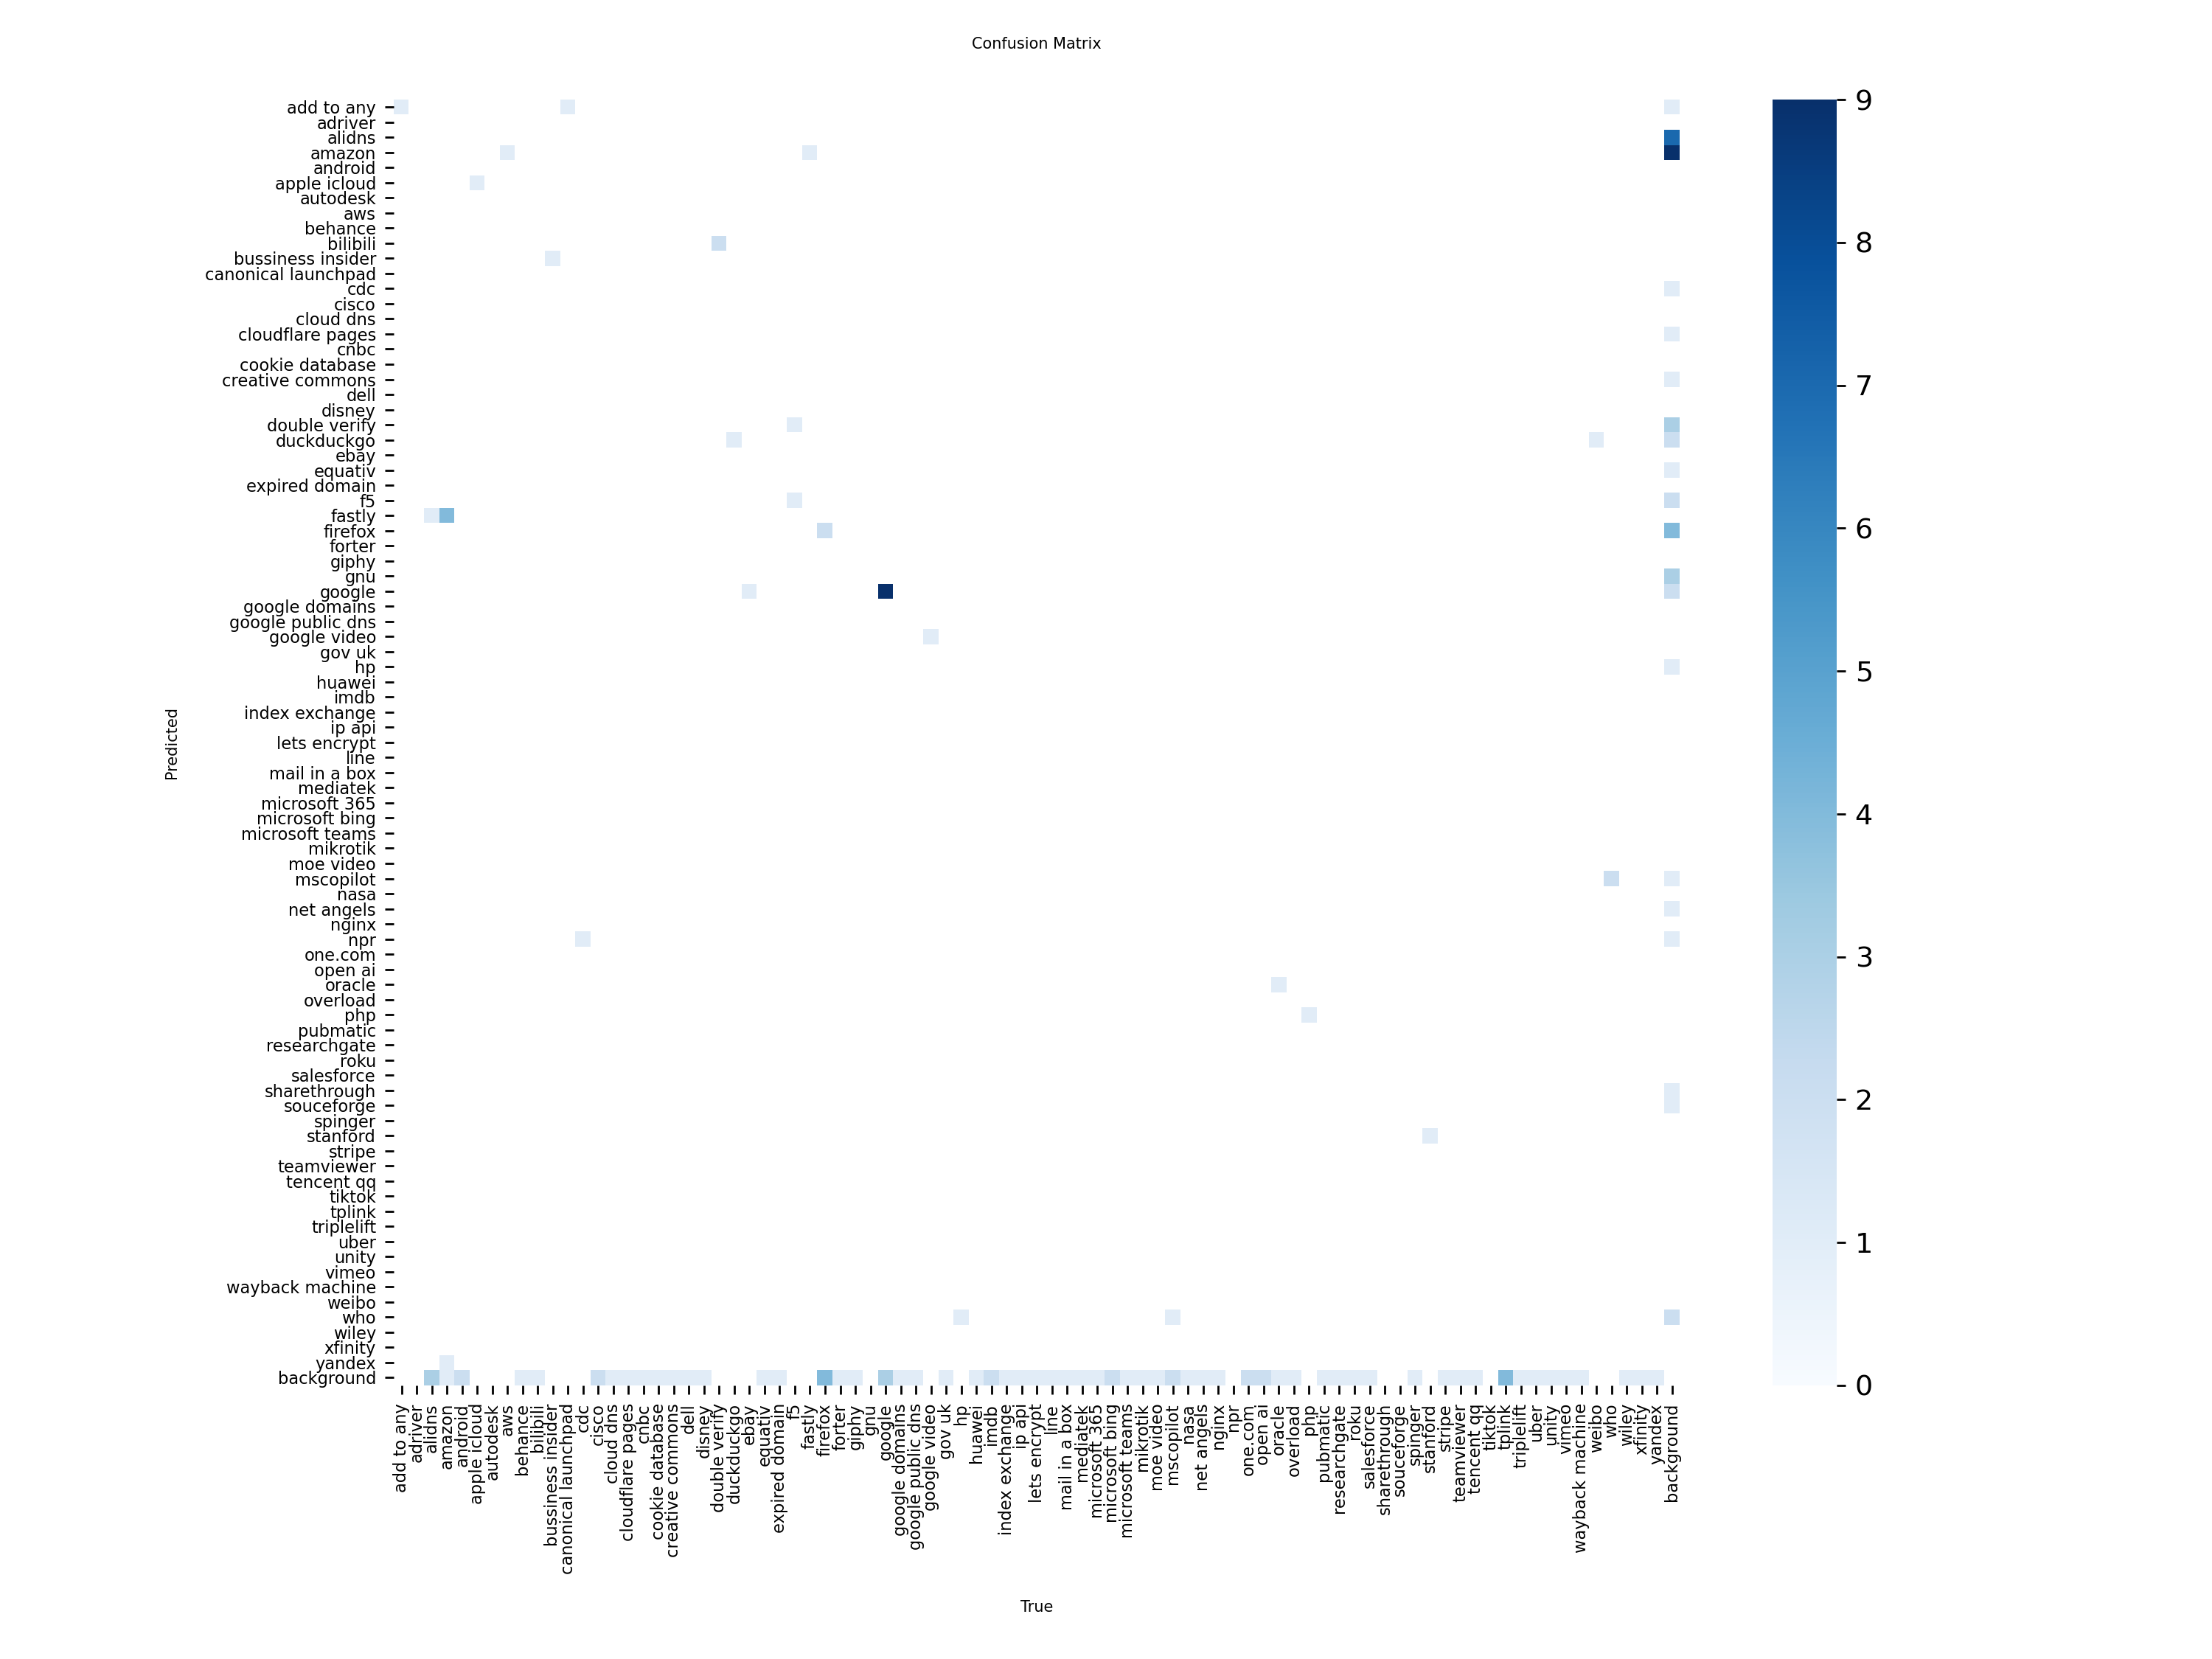

In [10]:
# Cell 4: Save Model to Drive & Display Metrics (FIXED PATH)
import os
import shutil
from IPython.display import Image, display

# 1. Define paths
best_model_path = "/content/yolo_phishing_project/train_run3/weights/best.pt"
drive_save_path = "/content/drive/MyDrive/Project3_Models/yolo_logo_detector.pt"

# 2. Save to Google Drive
print(f">>> Saving best model from: {best_model_path}")
print(f">>> To Google Drive: {drive_save_path}")

save_dir = os.path.dirname(drive_save_path)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if os.path.exists(best_model_path):
    shutil.copy(best_model_path, drive_save_path)
    print("🎉 SUCCESS! Model saved to Google Drive.")
else:
    print(f"❌ ERROR: Model file not found at {best_model_path}")
    print("   >> Hãy kiểm tra xem thư mục train_run hiện tại là số mấy?")

# 3. Display Training Results (Confusion Matrix & Loss)
print("\n>>> Training Results (Confusion Matrix):")
cm_path = "/content/yolo_phishing_project/train_run3/confusion_matrix.png"

if os.path.exists(cm_path):
    display(Image(filename=cm_path, width=600))
else:
    print("No confusion matrix found.")